In [1]:
using LinearAlgebra, Plots, CSV, DataFrames, Statistics, JuMP, Ipopt, CovarianceEstimation, Base

## The Marchenko-Pastur Distribution

In [2]:
n = 1000
A = randn(n,n)
histogram(eigvals(A*A'/n), bins = 50)
#plot!(size=(400,300))

InterruptException: InterruptException:

Loading the data

In [3]:
using Dates
data = DataFrame(CSV.File("large_stocks.csv"))
frmt = dateformat"dd-mm-yyyy"
data[:, :Date] = [DateTime(i, frmt) for i in data[:, :Column1]]
data = sort!(data, :Date)

12921×839 DataFrame
   Row │ Column1     AB         ABC        ABG        ABM        ABR        AB ⋯
       │ String15    Float64    Float64    Float64    Float64    Float64    Fl ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ 02-01-1970  -0.272699  -0.658871  -0.840099  -0.94095   -0.56365   -0 ⋯
     2 │ 05-01-1970  -0.290332  -0.661488  -0.863263  -0.941949  -0.565886  -0
     3 │ 06-01-1970  -0.172715  -0.603052  -0.828021  -0.938927  -0.597147  -0
     4 │ 07-01-1970  -0.191337  -0.604941  -0.830238  -0.939696  -0.598782  -0
     5 │ 08-01-1970  -0.276693  -0.649613  -0.86868   -0.941728  -0.568413  -0 ⋯
     6 │ 09-01-1970  -0.284334  -0.652893  -0.865124  -0.943266  -0.585315  -0
     7 │ 12-01-1970  -0.261371  -0.644503  -0.868726  -0.942815  -0.574605  -0
     8 │ 13-01-1970  -0.214641  -0.598341  -0.846499  -0.939394  -0.577936  -0
     9 │ 14-01-1970  -0.220579  -0.589157  -0.838605  -0.937989  -0.580622  -0 ⋯
    10 │ 15-01-1970  -0.260449  -0.641063  -0.865308  -0.942313  -0.583567  -0
    11 │ 16-01-1970  -0.269563  -0.647985  -0.868496  -0.944039  -0.587622  -0
   ⋮   │     ⋮           ⋮          ⋮          ⋮          ⋮          ⋮         ⋱
 12912 │ 11-03-2021   0.464487   0.293079   1.5955     0.752465   0.628825   0
 12913 │ 12-03-2021   0.710993   0.402907   2.25468    1.14894    0.994026   0 ⋯
 12914 │ 15-03-2021   0.350787   0.420055   1.78957    0.51075    0.31493    0
 12915 │ 16-03-2021   0.962945   0.401988   3.1039     0.945874   1.28375    0
 12916 │ 17-03-2021   1.1462     0.273743   3.03783    0.781006   1.89157    0
 12917 │ 18-03-2021   1.83015    0.360833   3.33214    1.03317    2.56798    0 ⋯
 12918 │ 19-03-2021   1.19482    0.347907   2.84933    1.09435    2.71205    0
 12919 │ 22-03-2021   0.505032   0.477085   1.78681    0.466942   0.279034   0
 12920 │ 23-03-2021   1.66884    0.538888   2.93627    1.40733    2.73302    0
 12921 │ 24-03-2021   1.36546    0.444834   2.38838    1.37678    2.74941    0 ⋯
                                              833 columns and 12900 rows omitted

In [4]:
data1 = data[:, 2:838]
df = last(data1, 800)

800×837 DataFrame
 Row │ AB        ABC        ABG        ABM          ABR        ABT       ACC   ⋯
     │ Float64   Float64    Float64    Float64      Float64    Float64   Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.190476  0.170703   0.143963    0.00990349  0.128342   0.468069  -0.22 ⋯
   2 │ 0.389873  0.128132   0.56452     0.35274     0.315047   0.488134  -0.03
   3 │ 0.186147  0.211239   0.187056   -0.00329441  0.128818   0.46827   -0.21
   4 │ 0.17094   0.239427   0.158015   -0.0293972   0.136182   0.531134  -0.22
   5 │ 0.170576  0.216008   0.114159   -0.0314651   0.150538   0.568345  -0.20 ⋯
   6 │ 0.192719  0.2649     0.159632   -0.0539551   0.12783    0.54834   -0.20
   7 │ 0.502169  0.173403   0.600467    0.289044    0.275229   0.672655  -0.08
   8 │ 0.184549  0.225305   0.143297   -0.0576497   0.110961   0.522556  -0.20
   9 │ 0.169165  0.141957   0.10747    -0.0584303   0.104336   0.488149  -0.20 ⋯
  10 │ 0.172043  0.120528   0.100306   -0.0600399   0.0902965  0.468935  -0.21
  11 │ 0.127119  0.0905167  0.0587327  -0.0731951   0.0933694  0.443041  -0.22
  ⋮  │    ⋮          ⋮          ⋮           ⋮           ⋮         ⋮            ⋱
 791 │ 0.464487  0.293079   1.5955      0.752465    0.628825   0.50493    0.11
 792 │ 0.710993  0.402907   2.25468     1.14894     0.994026   0.561547   0.25 ⋯
 793 │ 0.350787  0.420055   1.78957     0.51075     0.31493    0.478838  -0.03
 794 │ 0.962945  0.401988   3.1039      0.945874    1.28375    0.604942   0.70
 795 │ 1.1462    0.273743   3.03783     0.781006    1.89157    0.479683   0.62
 796 │ 1.83015   0.360833   3.33214     1.03317     2.56798    0.490159   0.90 ⋯
 797 │ 1.19482   0.347907   2.84933     1.09435     2.71205    0.614094   0.74
 798 │ 0.505032  0.477085   1.78681     0.466942    0.279034   0.557907  -0.08
 799 │ 1.66884   0.538888   2.93627     1.40733     2.73302    0.91802    1.05
 800 │ 1.36546   0.444834   2.38838     1.37678     2.74941    0.6935     0.73 ⋯
                                                831 columns and 779 rows omitted

In [5]:
S = cov(Array(df[1:500, :]))
Cor = cor(Array(df[1:500, :]))
heatmap(Cor)

In [6]:
S_test = cov(Array(df[500:800, :]))
Cor_test = cor(Array(df[500:800, :]))
heatmap(Cor_test)

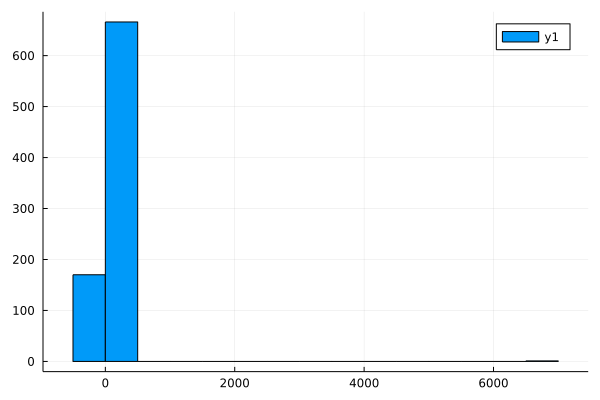

In [7]:
histogram(eigvals(S), bins = 20)

# Naive Markowitz optimization

In [8]:
mu = mean.(eachcol(df[1:500, :]))
mu_test = mean.(eachcol(df[500:800, :]))

837-element Vector{Float64}:
  0.07542642508697167
  0.14989876351986545
  0.4276827393634821
  0.019706716473898597
  0.0708850324218552
  0.44887076800128173
 -0.1406229959273248
 -0.011308114091604196
 -0.22746584749456122
  0.09171886515228544
 -0.5124116718413849
  0.3992760598928355
 -0.04856358824847105
  ⋮
  0.0172951988941267
  0.24257094058518752
 -0.04072020198777653
 -0.08066391523226737
 -0.2316971522687852
 -0.3613024394239528
 -0.43193153251230293
  0.3726044875903923
 -0.6015445001012409
  0.05289367722422943
 -0.14893708942173692
 -0.19559479439682945

In [9]:
function solve_portfolio_optimization(r, S, mu)
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, x[1:size(S)[1]])
    @objective(model, Min, x' * S * x)
    @constraint(model, sum(x) == 1)
    @constraint(model, sum(mu[i] * x[i] for i in 1:837) >= r)
    optimize!(model)
    return value.(x)
end

solve_portfolio_optimization (generic function with 1 method)

In [38]:
a = solve_portfolio_optimization(0.24, S, mu)

837-element Vector{Float64}:
 -0.024238669365204725
  0.017178127840375913
 -0.01672731552811942
  0.007389499571448339
 -0.012345278502899015
  0.002100453067638378
 -0.011544513205412669
  0.03727055201405111
  0.0035847017896925544
  0.035108638219043475
 -0.02911412806253781
 -0.006917312703570872
 -0.0022342611756639937
  ⋮
  0.002684688136734825
 -0.011788381355347368
  0.008187754849848055
  0.005606814024688222
  0.01552476325662019
 -0.014477842777250477
  0.008073876948315115
  0.010351098656442159
  0.019048240962855376
  0.04274932309089152
  0.018902445303688807
  0.03014125576138671

In [39]:
a'*S*a

1.6476221197181266e-11

In [40]:
a'*S_test*a

0.24198530174096752

In [41]:
a'*mu_test

-0.11993007765863616

In [26]:
portf = [solve_portfolio_optimization(r, S, mu) for r in range(0.24,stop=1,length=20)]

20-element Vector{Vector{Float64}}:
 [-0.024238669365204725, 0.017178127840375913, -0.01672731552811942, 0.007389499571448339, -0.012345278502899015, 0.002100453067638378, -0.011544513205412669, 0.03727055201405111, 0.0035847017896925544, 0.035108638219043475  …  0.008187754849848055, 0.005606814024688222, 0.01552476325662019, -0.014477842777250477, 0.008073876948315115, 0.010351098656442159, 0.019048240962855376, 0.04274932309089152, 0.018902445303688807, 0.03014125576138671]
 [-0.026802040551966076, 0.020858505358869094, -0.018156336149879427, 0.007136959049499612, -0.01455230292954341, 0.0015847247460940464, -0.013806888510073665, 0.042685338938691246, 0.004902965644888335, 0.04030981989434677  …  0.009336897948389059, 0.006794724984617191, 0.01765220596498059, -0.0171108939086909, 0.009237020664750201, 0.011581707494836248, 0.021840547816365016, 0.04758676326936118, 0.021446618920676692, 0.03381037451980128]
 [-0.029374029126710936, 0.02455134026190329, -0.019590094216573577, 0.006

In [29]:
[i'*mu for i in portf]

20-element Vector{Float64}:
 0.2794093584420627
 0.31846519720530503
 0.3576555139515864
 0.39695581797749135
 0.43634660021235483
 0.4758123288217454
 0.5153405995156203
 0.5549214531627685
 0.5945468418258711
 0.6342102160712727
 0.6739062073487065
 0.7136303834016503
 0.7533790592834424
 0.7931491507264493
 0.8329380595194786
 0.8727435835830556
 0.9125638456620653
 0.9523972366524058
 0.9922423701556682
 1.0872276482141823

In [30]:
[i'*S*i for i in portf]

20-element Vector{Float64}:
 1.6476221197181266e-11
 1.886999933553363e-11
 2.1598143892428635e-11
 2.4666728869172768e-11
 2.807959406800721e-11
 3.183929441312695e-11
 3.594763942534351e-11
 4.0406159640439554e-11
 4.5215986320832466e-11
 5.037809352994917e-11
 5.589335962326557e-11
 6.176242006789934e-11
 6.798603454727717e-11
 7.456462302467604e-11
 8.149871591051308e-11
 8.878882325157583e-11
 9.643504849791725e-11
 1.0443805736117356e-10
 1.1279803030839679e-10
 1.1551414770149475e-10

In [28]:
[i'*mu for i in portf] ./[i'*S*i for i in portf]

20-element Vector{Float64}:
 1.695833984614529e10
 1.6876799598270844e10
 1.655954862292425e10
 1.6092762850026161e10
 1.55396334845706e10
 1.4944185717431408e10
 1.4335867605044994e10
 1.3733585624093521e10
 1.3149040642555756e10
 1.2589007872920843e10
 1.2056999469901136e10
 1.1554443343008762e10
 1.1081379643631754e10
 1.0637070484001087e10
 1.022025991715082e10
 9.829430683073797e9
 9.462989440833582e9
 9.119254615764942e9
 8.796628517739326e9
 9.412073497903786e9

## Eigenvalue clipping

In [31]:
vals, vect = eigen(S)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
837-element Vector{Float64}:
   -9.115154464248363e-13
   -4.635699908910219e-14
   -7.970979724309967e-15
   -3.0407446049842415e-15
   -7.779756513925802e-16
   -7.64044113388562e-16
   -7.146188674135467e-16
   -4.510825272751922e-16
   -4.1355462501361075e-16
   -4.0105236577257807e-16
   -3.4786825000069754e-16
   -3.468127665051041e-16
   -2.624847694210928e-16
    ⋮
    0.6411289417339148
    0.6635147338030194
    0.7870085293864602
    0.9851773106832399
    1.3174461487428397
    3.3259706006348453
    3.5171579915438116
    6.615609832828832
    9.671390458747569
   14.699212885401414
   35.471497430311274
 6812.92462528911
vectors:
837×837 Matrix{Float64}:
  0.0550727   -0.00471099  -0.033479    …   0.0114242    -0.000129864
  0.0216556    0.0316723   -0.0597189      -3.63951e-5   -0.000236293
 -0.0343115    0.0350071    0.0060607      -0.00578195    0.000329688
 -0.0144685    0.0652294    0.00721911     -0.0

In [15]:
threshold = (1+ sqrt(837/500))^2

5.261663038341738

In [16]:
mean_noise = mean([i for i in vals if i < threshold])
new_vals = append!([i for i in vals if i > threshold], [mean_noise for i = 1:832])
S_sub = vect'*Diagonal(new_vals)*vect

837×837 Matrix{Float64}:
  4.92144    -2.21483     4.88233    -3.63646    …  -3.52326    -0.0330225
 -2.21483     1.16805    -2.1936      1.64906        1.55586     0.0159414
  4.88233    -2.1936      5.04046    -3.66099       -3.58512    -0.0325359
 -3.63646     1.64906    -3.66099     2.74898        2.6306      0.0244534
 -3.5701      1.63383    -3.57345     2.65508        2.57332     0.0242158
  0.0923704  -0.0142039   0.0433135  -0.0576905  …  -0.0535022  -0.000584323
  9.98982    -4.47292    10.1176     -7.46904       -7.27752    -0.066896
  4.80837    -2.18449     4.92358    -3.59374       -3.52538    -0.0323996
 -3.20489     1.35125    -3.23939     2.36631        2.34301     0.0208249
 -8.63377     3.87518    -8.74924     6.42864        6.28971     0.0578876
  6.46759    -2.91408     6.56849    -4.84403    …  -4.71315    -0.0433481
  2.69532    -1.19139     2.78401    -2.03235       -1.9958     -0.0179107
 -2.91675     1.3182     -2.92482     2.16658        2.10725     0.0196474

In [17]:
vals_cor, vect_cor = eigen(Cor)
mean_noise_cor = mean([i for i in vals_cor if i < threshold])
new_vals_cor = append!([i for i in vals_cor if i > threshold], [mean_noise_cor for i = 1:826])
Cor_sub = vect_cor'*Diagonal(new_vals_cor)*vect_cor                                

837×837 Matrix{Float64}:
  0.852635    -0.0430936   -0.122875   …  -0.517459   -0.00767094  -0.337629
 -0.0430936    0.444364     0.110809      -0.289775    0.179625     0.12818
 -0.122875     0.110809     0.655442      -0.605473    0.431264     0.24852
 -0.17634     -0.283461    -0.413442       0.751024   -0.350726    -0.346545
  0.1242       0.0149863    0.407323      -0.495408    0.103819     0.076734
  0.264316    -0.0566638   -0.140427   …   0.291066   -0.472044     0.0154766
  0.229337     0.00898793   0.379128      -0.659637   -0.014347     0.206734
 -0.300198    -0.0783474   -0.0797826      0.384192    0.0799035    0.117599
 -0.112933    -0.0527196   -0.697396       1.47853    -1.25687     -0.0662338
  0.794131     0.0276467   -0.126372      -1.25316     0.466216    -0.186655
  0.165239     0.264716    -0.262949   …  -0.326246    0.317318     0.12396
 -0.668891     0.138738     0.595973       0.0655398   0.13375      0.768508
  0.0876416   -0.078516    -0.0318882      0.205346 

In [42]:
a_sub = solve_portfolio_optimization(0.24, S_sub, mu)

837-element Vector{Float64}:
 0.001335844492125899
 0.0011130725451692122
 0.0012807440922019502
 0.0010136656257067633
 0.0012419263789601217
 0.0013277830493811842
 0.0013480535613655054
 0.0011811929867289303
 0.0011341774397119714
 0.0012634690773197547
 0.0012229003790354112
 0.0012346183695076385
 0.0012190189820025581
 ⋮
 0.0011905802127472407
 0.0012630722225171797
 0.0018550341751496751
 0.0012986168463471847
 0.0012609960707545636
 0.0011031076386081027
 0.0011599072419854178
 0.0012683662641435568
 0.0009975945645081168
 0.0012003189609250911
 0.0012229756624435864
 0.0011924968547332166

In [43]:
a_sub'*S*a_sub

0.4602491632819696

In [44]:
a_sub'*mu

0.24054190038690026

In [22]:
a_sub'*S_test*a_sub

0.3663783180046436

In [23]:
(a_sub'*mu_test) / (a_sub'*S_test*a_sub)

0.32997076247885293

In [32]:
portf_sub = [solve_portfolio_optimization(r, S_sub, mu) for r in range(0.24,stop=1,length=20)]

20-element Vector{Vector{Float64}}:
 [0.001335844492125899, 0.0011130725451692122, 0.0012807440922019502, 0.0010136656257067633, 0.0012419263789601217, 0.0013277830493811842, 0.0013480535613655054, 0.0011811929867289303, 0.0011341774397119714, 0.0012634690773197547  …  0.0018550341751496751, 0.0012986168463471847, 0.0012609960707545636, 0.0011031076386081027, 0.0011599072419854178, 0.0012683662641435568, 0.0009975945645081168, 0.0012003189609250911, 0.0012229756624435864, 0.0011924968547332166]
 [0.001340940459644524, 0.0010986345824449974, 0.001293912619323872, 0.0010037025083134686, 0.0012647019553401482, 0.001352339203942876, 0.0013449444428077653, 0.0011890449222560166, 0.0011189094342454401, 0.0012821168235445418  …  0.0019731205065962607, 0.0013106093116556545, 0.0012572117058544672, 0.0010738974800614423, 0.0011546899312125608, 0.0012985697156067061, 0.0009711627067261787, 0.0012145236205466266, 0.0012328621401956753, 0.0011900823599460162]
 [0.0013460459578945028, 0.00108416961

In [33]:
[i'*mu for i in portf_sub] ./[i'*S*i for i in portf_sub]

20-element Vector{Float64}:
 0.5226340851369096
 0.4162428315456906
 0.3448599443996681
 0.2939122072203768
 0.2558380961406569
 0.2263608296251533
 0.2028930387131707
 0.18378313955578277
 0.16792988041078202
 0.15457197943104245
 0.14316697459964142
 0.13331822469196972
 0.12472919731893553
 0.11717387941484597
 0.11047706374107649
 0.10450087878978673
 0.09913537669342211
 0.09429182443097213
 0.08989783588814629
 0.08589613231739236

In [45]:
[i'*mu for i in portf_sub]

20-element Vector{Float64}:
 0.24054190038690026
 0.28036738797506244
 0.3202673591857782
 0.3602051452691804
 0.4001639185715981
 0.4401351858371952
 0.48011432352889544
 0.5200986550582686
 0.5600865499412269
 0.600076971418079
 0.6400692356872992
 0.6800628772772581
 0.7200575704990342
 0.7600530818939278
 0.8000492404962521
 0.8400459186956608
 0.8800430196018916
 0.9200404685091679
 0.9600382070095583
 1.0000116256587295

In [48]:
[i'*mu_test for i in portf_sub]

20-element Vector{Float64}:
 0.04650033295295664
 0.057914738187988916
 0.06935049121564002
 0.08079708238510634
 0.09224968871311551
 0.10370587594295178
 0.11516431891991918
 0.12662425050563167
 0.1380852033861053
 0.14954688041513525
 0.16100908560775987
 0.17247168555511674
 0.18393458691127504
 0.195397722764491
 0.20686104411422943
 0.21832451438587652
 0.2297881058098285
 0.24125179697461457
 0.25271557113972276
 0.2641723749787338

In [49]:
[i'*S_test*i for i in portf_sub]

20-element Vector{Float64}:
 0.10329292008308787
 0.129665271967298
 0.16117352998697132
 0.19781022528443054
 0.23957118513360612
 0.2864539506356779
 0.338457003424363
 0.3955793673688274
 0.45782039280891124
 0.5251796342290413
 0.5976567780521346
 0.6752515984789885
 0.7579639296152235
 0.845793647385834
 0.9387406575021604
 1.0368048872798716
 1.1399862799599232
 1.2482847906974055
 1.3617003836809587
 1.4801586677921494

## Refining the eigenvalue threshold

In [46]:
Q = 837/500
t1 = (1+ 1/Q + 2*sqrt(1/Q))

3.143167884314062

In [50]:
mean_noise_1 = mean([i for i in vals if i < t1])
new_vals_1 = append!([i for i in vals if i > t1], [mean_noise_1 for i = 1:830])
S_sub_1 = vect'*Diagonal(new_vals_1)*vect

837×837 Matrix{Float64}:
   4.65505     -6.72205     14.9463      7.48434   …   2.13981    -0.0635812
  -6.72205     10.3014     -22.6118    -11.36         -3.17348     0.0974915
  14.9463     -22.6118      50.0701     25.1478        7.03547    -0.214163
   7.48434    -11.36        25.1478     12.6768        3.54088    -0.107659
   0.436631    -0.585599     1.37049     0.694206      0.207478   -0.00545717
  -5.98785      9.02969    -20.0003    -10.0482    …  -2.82017     0.0854308
   6.73437    -10.2709      22.683      11.3777        3.16104    -0.0974417
  -1.2939       1.70309     -3.87295    -1.94349      -0.591112    0.0160144
 -11.136       16.9895     -37.5609    -18.8943       -5.25658     0.161177
  18.2944     -27.661       61.2338     30.802         8.64227    -0.262056
  -1.43983      2.18937     -4.84936    -2.46397   …  -0.694325    0.0207707
  -2.12581      3.17634     -7.01138    -3.53235      -1.00112     0.0300929
  10.6566     -16.1591      35.7676     17.991        

In [51]:
a_sub_1 = solve_portfolio_optimization(0.5, S_sub_1, mu)

837-element Vector{Float64}:
 0.0011564471338060562
 0.0011528011070758982
 0.0010128904038789557
 0.0007867951981738316
 0.0013586291042413123
 0.0016685693271438356
 0.0012209462426664716
 0.0013755447024152267
 0.0012429387415016234
 0.0009414567877288007
 0.0011109625523913324
 0.0013459440599144963
 0.0010692295351489062
 ⋮
 0.001386170258785602
 0.0013192616507295154
 0.002531319456806583
 0.0012848993329903423
 0.0013478960077166848
 0.0007394836164914864
 0.0011398911221549872
 0.0015834308782999489
 0.000840341540923965
 0.0013589509667498632
 0.0012183202627216627
 0.0011897341607352884

In [52]:
(a_sub_1'*mu_test) / (a_sub_1'*S_test*a_sub_1)

0.3275954788670683

In [53]:
portf_sub_1 = [solve_portfolio_optimization(r, S_sub_1, mu) for r in range(0.24,stop=1,length=20)]

20-element Vector{Vector{Float64}}:
 [0.0011190654595423933, 0.0012126500058794946, 0.0009836792259833296, 0.0008825862915538933, 0.0012038325637378458, 0.001486698195985509, 0.0012744554622103979, 0.0013362768263327379, 0.0012847474975817403, 0.0008880885070023805  …  0.0017843240591954705, 0.0012286665789417149, 0.0013679407404418205, 0.0009357846606390471, 0.0011697434084711753, 0.0013978554334793131, 0.0009929042440949077, 0.0012413682179216437, 0.0011554409553199598, 0.0012041448493032062]
 [0.0011247999074814944, 0.001203469026132405, 0.0009881602980618834, 0.0008678916838691751, 0.0012275787634550507, 0.00151459770967535, 0.0012662470060824584, 0.0013423006226295528, 0.0012783339235574354, 0.0008962753427986988  …  0.0018989151336478091, 0.001237292832510166, 0.001364865825297777, 0.0009056715600418032, 0.001165163988603879, 0.0014263231987198823, 0.0009695007209562456, 0.0012594057233291575, 0.0011650868077799409, 0.001201934211470978]
 [0.0011305456856607475, 0.001194269906417

In [54]:
[i'*mu for i in portf_sub_1] ./[i'*S*i for i in portf_sub_1]

20-element Vector{Float64}:
 0.5238877899888787
 0.41718455803701854
 0.34559708480853574
 0.2945082937108567
 0.25633281511402967
 0.2267801487056242
 0.20325463587991052
 0.18409946395764334
 0.16820995728573282
 0.15482251773613062
 0.1433930710974007
 0.1335238256591807
 0.12491740976656401
 0.11734718606395335
 0.11063747479270597
 0.10465004119007774
 0.09927465419182731
 0.09442235718140346
 0.09002058546442522
 0.08601323855497507

In [57]:
[i'*mu_test for i in portf_sub_1]

20-element Vector{Float64}:
 0.04575474038120445
 0.057092302633414464
 0.06845226587785293
 0.07982384871437476
 0.09120201393572452
 0.10258417578046548
 0.1139689035988934
 0.12535535608881881
 0.13674301289212543
 0.14813153819308997
 0.15952070728929776
 0.1709103650633434
 0.18230040149723895
 0.19369073667954287
 0.20508131134131913
 0.21647208069656082
 0.22786301033220713
 0.2392540734121703
 0.2506452487209013
 0.26202560599531755

In [58]:
[i'*S_test*i for i in portf_sub_1]

20-element Vector{Float64}:
 0.10267529441474606
 0.1289875352412422
 0.16042985235585355
 0.19699523171961708
 0.23867970377334047
 0.2854809067711178
 0.3373973713144722
 0.3944281469349955
 0.4565725977862813
 0.5238302858900022
 0.59620090177881
 0.6736842218440653
 0.7562800812905122
 0.8439883565150068
 0.936808953347394
 1.0347417990145737
 1.1377868365642145
 1.2459440209016415
 1.359213315943101
 1.4774788324770147

## Standardized returns

In [70]:
size(df)

(800, 837)

In [71]:
df1 =df .- mean(eachcol(df))
for i=1:size(df)[2]
    df1[:, i] /= std(df1[:,i])
end

In [72]:
S1 = cov(Array(df1))
vals, vect = eigen(S1)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
837-element Vector{Float64}:
  -3.365467453745287e-15
  -1.1705604668255868e-15
  -4.583854319338207e-16
  -3.5386762336885195e-16
  -2.9152912876629677e-16
  -2.786609223942192e-16
  -2.2124733458334892e-16
  -2.1284368111347352e-16
  -1.80031770741218e-16
  -1.616151508922465e-16
  -9.081717853871157e-17
  -8.564287145732281e-17
  -7.278780558346869e-17
   ⋮
   6.367580979282631
   7.76333850241523
   8.983073877410812
  13.248631032899137
  21.255985833166175
  30.669890481967588
  41.06124498764031
  54.726128686659386
  85.13047801612215
 103.4258234600515
 141.57930142483926
 250.87691616745707
vectors:
837×837 Matrix{Float64}:
 -0.00711816  -0.0166333    0.00268577  …   0.00900381  -0.012336
 -0.0172735    0.0395023   -0.0141626      -0.0419359   -0.03974
 -0.0407259   -0.0314464    0.00146514     -0.0362435   -0.00317378
 -0.0193776    0.00601446  -0.0337528      -0.0193993   -0.0411703
  0.021597    -0.0131069  

In [74]:
threshold

5.261663038341738

In [76]:
noise_eigen =Array([i for i in vals if i < threshold])
mean_noise = mean([i for i in vals if i < threshold])
new_vals = sort(append!([i for i in vals if i > threshold], [mean_noise for i = 1:length(noise_eigen)]))
SS = vect'*Diagonal(new_vals)*vect

837×837 Matrix{Float64}:
  3.0112     -2.0012     -0.32012     0.434743    …   1.19274      0.138452
 -2.0012      4.45211     0.616904   -0.244964       -0.714991    -0.219396
 -0.32012     0.616904    4.12924    -0.648316       -0.911092    -0.658361
  0.434743   -0.244964   -0.648316    0.45646         0.521378     0.0436547
 -0.418272   -0.0656043   0.583059   -0.137298       -0.343148    -0.057375
  0.814357   -0.19319    -1.83918     0.474097    …   0.980487     0.194966
 -0.280146    0.0238535   0.402279   -0.0871876      -0.14855     -0.0888778
  0.0302677  -0.0855527  -0.534825    0.0866346       0.14714      0.0637184
 -0.447745   -0.110836    0.429542   -0.128954       -0.246315    -0.13942
  0.115342   -0.21589    -0.529935    0.198343        0.170952     0.0748718
  0.0326966  -0.245595   -0.716276    0.246532    …   0.296018     0.108453
  0.175809    0.0620239  -0.442211    0.0516233       0.148464     0.0973994
  0.236568   -0.0444531  -0.691011    0.145354        0.159

In [77]:
vals_cov, vect_cov = eigen(S)
noise_eigen_cov = vals_cov[1:length(noise_eigen)]
mean_noise_cov = mean(noise_eigen_cov)
new_vals_cov = sort(append!([i for i in vals_cov[length(noise_eigen)+1:837]], [mean_noise_cov for i = 1:length(noise_eigen_cov)]))
Cov_sub = real(vect_cov'*Diagonal(new_vals_cov)*vect_cov)                                

837×837 Matrix{Float64}:
   9.199          14.4385       -23.775       …   -2.93944       0.0296342
  14.4385        124.014       -197.174          -28.8045        0.236108
 -23.775        -197.174        315.182           45.599        -0.379131
 -23.5983       -192.95         308.244           44.5844       -0.371341
  -0.088687       -0.0436447     -0.0507127       -0.0162551    -4.30169e-5
   0.0400858      -0.0600151      0.156417    …    0.00828524   -0.000119655
   0.000346859     0.00788669    -0.0313767       -0.0143249    -1.33435e-5
  -0.00750084      0.0140539      0.00213579       0.00640812    4.01158e-6
   0.0446287      -0.0901294      0.187768         0.00405014   -0.000151212
   0.0242498       0.0328325      0.0245527        0.00547895    0.000106957
  -0.000682587     0.0263326      0.00662972  …   -0.000909395  -5.80364e-5
  -0.0076795      -0.0396519     -0.00338109      -0.0254316     0.000147673
  -0.0266473      -0.0257344     -0.00959603      -0.00488618   -8

In [78]:
new_vals_cov

837-element Vector{Float64}:
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    0.005468818390640435
    ⋮
    0.6411289417339148
    0.6635147338030194
    0.7870085293864602
    0.9851773106832399
    1.3174461487428397
    3.3259706006348453
    3.5171579915438116
    6.615609832828832
    9.671390458747569
   14.699212885401414
   35.471497430311274
 6812.92462528911

In [79]:
portf_sub_2 = [solve_portfolio_optimization(r, Cov_sub, mu) for r in range(0.24,stop=1,length=20)]

20-element Vector{Vector{Float64}}:
 [-5.118201113528387e-5, 0.0008479093856327134, 0.001105072980405616, 0.0013626771466600384, 0.0011983902800061245, 0.0012655107679613107, 0.0013602543383780742, 0.001019282035959443, 0.0013214498790041177, 0.0010312131805328294  …  0.0017627426945938643, 0.0011886660610161595, 0.0010109680757989109, 0.0013488066643148793, 0.0010831162300249135, 0.0012511462911110605, 0.0009019971166623691, 0.0013371606343789177, 0.0012993998725707515, 0.0012077284963501838]
 [-5.100238637746744e-5, 0.0008552431285802555, 0.0011208863571657132, 0.001350989197348754, 0.0012144768430881218, 0.0012899269966180008, 0.0013583921516915661, 0.001020921196019741, 0.0013117653872581118, 0.0010523538369014759  …  0.001875510248256462, 0.0011966733700476653, 0.0010012516822688368, 0.001321993487733634, 0.0010752097760914356, 0.0012858224285453763, 0.0008806363282903446, 0.0013581991444294212, 0.001301312466382467, 0.001205243702201624]
 [-5.0822292746298945e-5, 0.00086259601294

In [80]:
[i'*mu for i in portf_sub_2] ./[i'*S*i for i in portf_sub_2]

20-element Vector{Float64}:
 0.5254361520876276
 0.4182665456499881
 0.3463572075366803
 0.2950497126671671
 0.2567231161801215
 0.227063606726736
 0.2034608346304747
 0.184248651329513
 0.16831632223617796
 0.1548962219541511
 0.14344153597392215
 0.13355256680446204
 0.12493059065611786
 0.11734799332434227
 0.11062837768396809
 0.10463297430784214
 0.09925114826655096
 0.09439363414808849
 0.08998762852973241
 0.08595568746469781

In [81]:
[i'*mu for i in portf_sub_2]

20-element Vector{Float64}:
 0.2410244252432888
 0.2807573570887163
 0.3205939935736904
 0.3604858948876732
 0.4004099683349636
 0.44035410832253613
 0.4803114724201713
 0.5202779498973893
 0.5602509439126454
 0.6002287436144254
 0.6402101810592967
 0.6801944342926484
 0.72018090944267
 0.7601691674877887
 0.8001588772886963
 0.8401497846013901
 0.8801416911139255
 0.920134439942946
 0.9601279053953309
 1.000304318954675

In [82]:
[i'*S*i for i in portf_sub_2]

20-element Vector{Float64}:
  0.4587130601609096
  0.6712402892572201
  0.9256166368062039
  1.2217801930019903
  1.5596958088263033
  1.9393425246366698
  2.360707274658105
  2.823781591578201
  3.3285598001987764
  3.8750379837675553
  4.463213369213278
  5.093083948648772
  5.76464823915729
  6.477905126052989
  7.2328537581424985
  8.029493476211176
  8.867823763108499
  9.747844208428319
 10.6695544830154
 11.63744190127619

In [85]:
[i'*mu_test for i in portf_sub_2] ./ [i'*S_test*i for i in portf_sub_2]

20-element Vector{Float64}:
 0.4454463893348672
 0.4431761977934012
 0.4277836430512374
 0.40666939105220584
 0.3837900049070482
 0.36113636262614374
 0.33963980070622285
 0.3196775852467487
 0.30134472393340195
 0.28459794736232585
 0.26933131509525965
 0.25541546470210735
 0.2427175302892947
 0.23111078459811743
 0.22047884268761875
 0.21071702671102813
 0.20173229348102467
 0.1934424798558024
 0.18577526929079569
 0.17863587650055393

## Relaxing the conservation of trace
But keeping the covariance matrix non-singular - we increase the weight of the "noise" in the new correlation matrix

In [ ]:
mean_noise_1 = mean([i for i in vals if i < t1])
new_vals_2 = append!([i for i in vals if i > t1], [200*mean_noise_1 for i = 1:830])
S_sub_2 = vect'*Diagonal(new_vals_2)*vect

837×837 Array{Float64,2}:
  4.48798    -0.661434    -4.83733   …   2.66172    -1.43204     0.042556  
 -0.661434    2.66792      1.70677      -0.965799    0.479359   -0.0153308 
 -4.83733     1.70677     13.9815       -6.44117     3.36292    -0.1027    
  4.86796    -1.63725    -11.4639        6.36721    -3.39345     0.101759  
 -0.0261383   0.106052     0.302254     -0.206773    0.0626758  -0.00316924
  2.06211    -0.740145    -4.96442   …   2.76451    -1.44645     0.0441065 
  1.14141    -0.382426    -2.68576       1.47782    -0.807832    0.0237174 
  3.08486    -1.12001     -7.45392       4.17828    -2.20745     0.0667651 
 -2.25394     0.796954     5.42289      -3.01797     1.56211    -0.0480092 
 -6.40224     2.18082     15.1479       -8.44304     4.4796     -0.134825  
 -7.07221     2.5236      17.0092    …  -9.54376     4.9908     -0.152186  
 -3.32708     1.16276      7.93098      -4.44549     2.3479     -0.0709836 
 -1.51302     0.581879     3.74312      -2.11657     1.07568  

In [ ]:
a_sub_2 = solve_portfolio_optimization(0.5, S_sub_2, mu)

837-element Array{Float64,1}:
  0.00016304850852149575
  1.1720272353646247e-5 
  0.0002843866103370516 
  3.3705446299021424e-5 
  0.00040563929737650413
  0.0003702118640391042 
  3.9372344639634114e-5 
  0.00018289514418506615
 -0.00012769530529296635
  0.00026200595702128904
 -0.00026906830404468046
  9.930099587892117e-5  
  0.00029451906495087696
  ⋮                     
  0.00016058208100751714
  0.0002724365921569199 
  0.001570445537758712  
  0.00016234970708308696
  2.3417239022889588e-5 
 -0.0003214225314054855 
 -4.791877044417147e-5  
  0.0004849842582956617 
 -0.00028404563202699435
  0.00032036841696804437
  0.00017563310417848752
  5.322857027505143e-5  

In [ ]:
(a_sub_2'*mu_test) / (a_sub_2'*S_test*a_sub_2)

0.36179344760392446

Thus, we can cross-validate on a validation set the best noise weight to get?

## Linear Shrinkage with RMT parametrization
Optimal shrinkage parameter from paper:

In [59]:
beta = tr((S - I) * (S-I)')/837

55441.60947370546

In [60]:
gamma = sum([tr((Array(df[k, :])*Array(df[k, :])' - S)*(Array(df[k, :])*Array(df[k, :])' - S)') for k=1:500])

2.758106231191464e12

In [61]:
alpha_opt = 1 - beta /(gamma / 837^2)

0.9859176298330592

In [62]:
S_shrink = alpha_opt * S + (1-alpha_opt)*I

837×837 Matrix{Float64}:
  0.0320729     0.00585969    0.00909      …   0.0235053     0.0136803
  0.00585969    0.0275755     0.0131627        0.000742814   0.0163617
  0.00909       0.0131627     0.0821239       -0.00156682    0.00765622
 -0.011385     -0.00262615    0.0120082       -0.00687299   -0.00922004
  0.0143058    -0.00305058    0.00678945       0.0390544    -0.0272041
  0.0170559     0.00576945    0.0205775    …   0.0449315     0.0218966
 -0.00907572   -0.00746016    0.00135841      -0.0208902    -0.0377568
 -0.00897708   -0.000899199   0.0341059        0.0111425    -0.00440109
  0.0112169     0.00467151    0.00415276       0.0717835     0.0884104
 -0.00217558   -0.0123799    -0.00137599       0.0349856    -0.0232435
  0.0125472     0.00727049   -0.0133896    …   0.0207491     0.0285237
 -0.0178127    -0.0065        0.0231262        0.0114072     0.000905741
  0.0357027     0.0061332    -0.0225929        0.0606356     0.0234999
  ⋮                                        ⋱   

In [ ]:
a_shrink = solve_portfolio_optimization(0.5, S_shrink, mu)

837-element Array{Float64,1}:
  0.00456811534775219   
  0.001280301276893578  
 -0.006836941261351609  
 -0.003157764578623055  
  0.0070555183988923395 
 -0.0073096293181842435 
  0.004820274631826864  
  0.0021011110928502883 
 -0.004381539997873014  
  0.006374607498359011  
 -0.007149296747918787  
  0.0001756485096736837 
  0.00971536918260327   
  ⋮                     
 -0.00010531515719948152
  0.006257514104015963  
  0.011398308403852921  
  0.0004511389517265    
  0.004959327230438439  
 -0.014754789932257425  
  0.0020579919247248626 
  0.01138594047507391   
 -0.011808041274787528  
  0.0018279891234316307 
  0.0004954282032432081 
  0.01430720226652053   

In [63]:
portf_shrink = [solve_portfolio_optimization(r, S_shrink, mu) for r in range(0.24,stop=1,length=20)]

20-element Vector{Vector{Float64}}:
 [0.0035098964154614797, -0.00030305199265496434, -0.003005420778620722, 0.0013837600864247456, 0.004738894084006413, -0.002077163649681242, 0.004223503157433656, 0.00018271009407748592, -0.002446884429668757, 0.0002418454376895272  …  0.007424164930046941, 0.003811806440150911, -0.0012740107759835883, -0.007088403134970959, -0.004112315751448997, 0.004274007442878429, -0.0069769672032101455, 0.005917568405563769, 0.001091119902233649, 0.004449911742515325]
 [0.0039259352642855684, -0.00023587172114703444, -0.003541760715669728, 0.0012425045310860074, 0.005355270172174856, -0.0026069512025226923, 0.004682474261713519, 0.0003190796819600848, -0.0028106085483306444, 0.0006435782221587365  …  0.008411035562454382, 0.003985985167209412, -0.001017629218353141, -0.008269014883340767, -0.004143565348383923, 0.005139124487867842, -0.007971886372912245, 0.006257389736796456, 0.0011635283092098281, 0.005501628422423153]
 [0.004341974479263898, -0.0001686913905

In [64]:
[i'*mu for i in portf_shrink] ./[i'*S*i for i in portf_shrink]

20-element Vector{Float64}:
 1912.3492609462585
 1791.5565330345382
 1673.4384851067302
 1563.1568045830306
 1462.3671433936404
 1371.1400854997407
 1288.8731669073086
 1214.7221311234196
 1147.7985118730394
 1087.261105665039
 1032.3479710527058
  982.3857762871568
  936.7856139528631
  895.0405977561041
  856.708349173681
  821.4064250917771
  788.8049790056792
  758.6172856670054
  730.5939110321798
  704.516853462547

In [68]:
[i'*mu_test for i in portf_shrink]

20-element Vector{Float64}:
 -0.07243864343558973
 -0.06720205268727257
 -0.06196545733024131
 -0.05672885914934358
 -0.05149225905054569
 -0.04625565756513802
 -0.04101905503533115
 -0.03578248975024867
 -0.03054588318044827
 -0.025309276421604812
 -0.020072669508152303
 -0.014836062466515261
 -0.00959930530611791
 -0.004362731170120544
  0.000873794346844905
  0.006110398469477678
  0.011347003377520416
  0.01658360356609903
  0.021820189102867784
  0.02705682609044926

In [69]:
[i'*S_test*i for i in portf_shrink]

20-element Vector{Float64}:
 0.0996363700097668
 0.13909309000644407
 0.18535186856542354
 0.23841270440161147
 0.29827559757400957
 0.3649405484475738
 0.43840755740247156
 0.518676016727714
 0.6057471380298631
 0.6996203188030069
 0.8002955590992962
 0.90777285896168
 1.0220555895767385
 1.1431364165847842
 1.2710179963876203
 1.4057034943747582
 1.5471910636949981
 1.6954805479468034
 1.8505716281242637
 2.0124663336765463

In [ ]:
(a_shrink'*mu_test) / (a_shrink'*S_test*a_shrink)

0.2282171870510487

### Comparison with other shrinkage methods

In [ ]:
LSE = LinearShrinkage
method = LSE(ConstantCorrelation())
S_ledoitwolf = cov(method, Array(df[1:500, :]))

837×837 Symmetric{Float64,Array{Float64,2}}:
  0.018211     0.0058245     0.00909953   …   0.023283      0.013709  
  0.0058245    0.0136585     0.0130558        0.000977319   0.0162883 
  0.00909953   0.0130558     0.0688753       -0.000969795   0.00812458
 -0.0109679   -0.00242234    0.0120761       -0.00626382   -0.00850091
  0.0141966   -0.00280905    0.00703491       0.038753     -0.0259928 
  0.0168722    0.00580633    0.0204944    …   0.0444626     0.0219943 
 -0.00875801  -0.00719371    0.00156249      -0.0201094    -0.036567  
 -0.00858079  -0.000705672   0.0337541        0.0114451    -0.00369032
  0.0111992    0.00476601    0.00450292       0.0708356     0.0871794 
 -0.00193858  -0.0119462    -0.000977237      0.0347386    -0.0221569 
  0.0124154    0.00723467   -0.0128231    …   0.0206812     0.0283357 
 -0.0171785   -0.00614512    0.0231019        0.0118275     0.00164036
  0.035294     0.00631882   -0.0213844        0.0603157     0.0241165 
  ⋮                             

In [ ]:
a_ld = solve_portfolio_optimization(0.5, S_ledoitwolf, mu)

837-element Array{Float64,1}:
  0.009057618730823008  
  0.01447689663473648   
 -0.014419829316835194  
  0.0021072675970361943 
 -0.004835801741661528  
 -0.015556697524361241  
  0.009136428706064275  
  0.00897548120323059   
  0.0007273743715210398 
  0.004649447802594748  
 -0.007133194838828179  
  0.005218264146555374  
  0.006147656423107602  
  ⋮                     
 -0.0013675522961613948 
  0.004382883229517408  
  0.0007146445097227875 
 -0.0023208324171128873 
  0.005728060157053709  
 -0.02438239353992364   
  0.00021290032009725672
  0.004839579326941252  
 -0.006387853226888973  
  0.007737834193425435  
  7.316884177758966e-5  
  0.007381482440321006  

In [ ]:
(a_ld'*mu_test) / (a_ld'*S_test*a_ld)

-0.22932616462238045

In [ ]:
method = LSE(target=DiagonalCommonVariance(), shrinkage=:oas)
S_chen_oas = cov(method, Array(df[1:500, :]))

837×837 Symmetric{Float64,Array{Float64,2}}:
  0.0513665     0.00590753    0.00916421   …   0.0236972     0.0137919  
  0.00590753    0.0468323     0.0132702        0.000748878   0.0164953  
  0.00916421    0.0132702     0.101826        -0.00157961    0.00771872 
 -0.011478     -0.00264759    0.0121062       -0.0069291    -0.00929532 
  0.0144226    -0.00307549    0.00684488       0.0393733    -0.0274262  
  0.0171951     0.00581655    0.0207455    …   0.0452984     0.0220754  
 -0.00914982   -0.00752107    0.00136951      -0.0210608    -0.038065   
 -0.00905037   -0.00090654    0.0343844        0.0112335    -0.00443702 
  0.0113085     0.00470965    0.00418666       0.0723695     0.0891322  
 -0.00219334   -0.012481     -0.00138722       0.0352712    -0.0234332  
  0.0126496     0.00732985   -0.0134989    …   0.0209185     0.0287566  
 -0.0179581    -0.00655307    0.023315         0.0115003     0.000913136
  0.0359942     0.00618327   -0.0227774        0.0611307     0.0236917  
  ⋮   

In [ ]:
a_oas = solve_portfolio_optimization(0.5, S_chen_oas, mu)

837-element Array{Float64,1}:
  0.004360837600093767  
  0.00026107643324992693
 -0.0046671280568121145 
 -0.001597309609228807  
  0.006287128884848529  
 -0.005267742262032253  
  0.00478986283113562   
  0.001155281542817795  
 -0.004948133953771093  
  0.004635551263132218  
 -0.0072678751685188656 
  5.543912883827151e-7  
  0.009636927251347334  
  ⋮                     
 -0.0003673738224110684 
  0.005926596429870127  
  0.012612527913580102  
  0.001879519956282219  
  0.005618089223691504  
 -0.013569637842896996  
  0.002830611113215285  
  0.011081318689189877  
 -0.012135043898401907  
  0.0008804703373593873 
  0.0003409136489410191 
  0.01432595720958386   

In [ ]:
(a_oas'*mu_test) / (a_oas'*S_test*a_oas)

0.3699207623474167